<a href="https://colab.research.google.com/github/pchandrasekaran1595/Kaggles/blob/main/COVID_19_Radiography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

!mkdir ~/.data
!unzip -q covid19-radiography-database.zip -d /.data

Saving kaggle.json to kaggle.json
kaggle.json
100% 1.14G/1.14G [00:11<00:00, 118MB/s] 
100% 1.14G/1.14G [00:11<00:00, 107MB/s]


In [ ]:
import os

root_dir = "/.data/COVID-19 Radiography Database"

normal_dir = os.path.join(root_dir, "NORMAL")
covid_dir  = os.path.join(root_dir, "COVID")
pnemon_dir = os.path.join(root_dir, "Viral Pneumonia")  

In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch, torchvision
from torch import nn, optim
from torchvision import models, transforms
from torch.utils.data import DataLoader as DL
from torch.utils.data import Dataset
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from time import time
import random as r
import gc

seed = 42

In [ ]:
def breaker():
    print("\n" + 50*"-" + "\n")

def head(x=None, no_of_ele=5):
    print(x[:no_of_ele])

def getFileNames(path):
    f_names = []
    for _, _, filenames in os.walk(path):
        for filename in filenames:
            f_names.append(filename)
    return f_names

def getImages(path=None, filenames=None, size=None, color=False):
    images = []
    for name in filenames:
        try:
            if not color:
                image = cv2.imread(os.path.join(path, name), cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(os.path.join(path, name), cv2.IMREAD_COLOR)
        except e:
            print(e)

        if size:
            image = cv2.resize(src=image, dsize=(size, size), interpolation=cv2.INTER_LANCZOS4)
        
        if not color:
            images.append(image.reshape(size, size, 1))
        else:
            images.append(image)
        
    return np.array(images)

# Data Processing

**Data Input**

In [ ]:
start_time = time()

cov_filenames = getFileNames(covid_dir)
nor_filenames = getFileNames(normal_dir)
pne_filenames = getFileNames(pnemon_dir)

size = 256

cov_images = getImages(path=covid_dir, filenames=cov_filenames, size=size, color=False)
nor_images = getImages(path=normal_dir, filenames=nor_filenames, size=size, color=False)
pne_images = getImages(path=pnemon_dir, filenames=pne_filenames, size=size, color=False)

images = np.concatenate((cov_images, nor_images, pne_images), axis=0)
labels = np.concatenate((np.ones((cov_images.shape[0], 1)) * 0, 
                         np.ones((nor_images.shape[0], 1)) * 1, 
                         np.ones((pne_images.shape[0], 1)) * 2), axis=0)
labels = labels.astype("int")

breaker()
print("Time Taken to process Data : {:.2f} seconds".format(time() - start_time))

del cov_filenames, nor_filenames, pne_filenames, cov_images, nor_images, pne_images, start_time

breaker()
print("Garbage Collected : {}".format(gc.collect()))
breaker()

tr_images, va_images, tr_labels, va_labels = train_test_split(images, labels, 
                                                              test_size=0.2, shuffle=True, random_state=seed, 
                                                              stratify=labels)


--------------------------------------------------

Time Taken to process Data : 33.30 seconds

--------------------------------------------------

Garbage Collected : 0

--------------------------------------------------



**Dataset Template**

In [ ]:
class DS(Dataset):
    def __init__(this, X=None, y=None, transform=None, mode="train"):
        this.transform = transform
        this.mode = mode
        this.X = X
        if mode == "train" or mode == "valid":
            this.y = y

    def __len__(this):
        return this.X.shape[0]

    def __getitem__(this, idx):
        img = this.transform(this.X[idx])
        if this.mode == "train" or this.mode == "valid":
            return img, torch.LongTensor(this.y[idx])
        else:
            return img

# CNN Configuration and Setup

**Config**

In [ ]:
class CFG():
    tr_batch_size = 64
    ts_batch_size = 64

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    OL = 3

    def __init__(this, in_channels=None, filter_sizes=None, HL=None, AP_size=None, epochs=None, n_folds=None):
        this.in_channels = in_channels
        this.filter_sizes = filter_sizes
        this.HL = HL
        this.AP_size = AP_size
        this.epochs = epochs
        this.n_folds = n_folds

**Setup**

In [ ]:
class CNN_8BN(nn.Module):
    def __init__(this, in_channels=None, filter_sizes=None, HL=None, OL=None, AP_size=None, DP=0.5):

        super(CNN_8BN, this).__init__()

        this.DP_ = nn.Dropout(p=DP)
        this.AP_ = nn.AdaptiveAvgPool2d(output_size=AP_size)
        this.MP_ = nn.MaxPool2d(kernel_size=2)

        this.CN1 = nn.Conv2d(in_channels=in_channels, out_channels=filter_sizes[0], kernel_size=3, stride=1, padding=1)
        this.BN1 = nn.BatchNorm2d(num_features=filter_sizes[0], eps=1e-5)

        this.CN2 = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=3, stride=1, padding=1)
        this.BN2 = nn.BatchNorm2d(num_features=filter_sizes[1], eps=1e-5)

        this.CN3 = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=3, stride=1, padding=1)
        this.BN3 = nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5)

        this.CN4 = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN4 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)

        this.CN5 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN5 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)

        this.FC1 = nn.Linear(in_features=filter_sizes[3] * (AP_size**2), out_features=HL[0])
        this.FC2 = nn.Linear(in_features=HL[0], out_features=HL[1])
        this.FC3 = nn.Linear(in_features=HL[1], out_features=OL)
    
    def getOptimizer(this, A_S=True, lr=1e-3, wd=0):
        if A_S:
            return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
        else:
            return optim.SGD(this.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    
    def getMultiStepLR(this, optimizer=None, milestones=None, gamma=0.1):
        return optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=gamma)

    def getPlateauLR(this, optimizer=None, patience=5, eps=1e-8):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)

    def forward(this, x):
        x = F.relu(this.MP_(this.BN1(this.CN1(x))))
        x = F.relu(this.MP_(this.BN2(this.CN2(x))))
        x = F.relu(this.MP_(this.BN3(this.CN3(x))))
        x = F.relu(this.MP_(this.BN4(this.CN4(x))))
        x = F.relu(this.MP_(this.BN5(this.CN5(x))))

        x = this.AP_(x)
        x = x.view(x.shape[0], -1)

        x = F.relu(this.DP_(this.FC1(x)))
        x = F.relu(this.DP_(this.FC2(x)))
        x = F.log_softmax(this.FC3(x), dim=1)

        return x

#########################################################################################################

class CNN_11BN(nn.Module):
    def __init__(this, in_channels=None, filter_sizes=None, HL=None, OL=None, AP_size=None, DP=0.5):

        super(CNN_11BN, this).__init__()

        this.DP_ = nn.Dropout(p=DP)
        this.AP_ = nn.AdaptiveAvgPool2d(output_size=AP_size)
        this.MP_ = nn.MaxPool2d(kernel_size=2)

        this.CN1 = nn.Conv2d(in_channels=in_channels, out_channels=filter_sizes[0], kernel_size=3, stride=1, padding=1)
        this.BN1 = nn.BatchNorm2d(num_features=filter_sizes[0], eps=1e-5)

        this.CN2 = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=3, stride=1, padding=1)
        this.BN2 = nn.BatchNorm2d(num_features=filter_sizes[1], eps=1e-5)

        this.CN3_1 = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=3, stride=1, padding=1)
        this.BN3_1 = nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5)
        this.CN3_2 = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[2], kernel_size=3, stride=1, padding=1)
        this.BN3_2 = nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5)

        this.CN4_1 = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN4_1 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)
        this.CN4_2 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN4_2 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)

        this.CN5_1 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN5_1 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)
        this.CN5_2 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN5_2 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)

        this.FC1 = nn.Linear(in_features=filter_sizes[3] * (AP_size**2), out_features=HL[0])
        this.FC2 = nn.Linear(in_features=HL[0], out_features=HL[1])
        this.FC3 = nn.Linear(in_features=HL[1], out_features=OL)
    
    def getOptimizer(this, A_S=True, lr=1e-3, wd=0):
        if A_S:
            return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
        else:
            return optim.SGD(this.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    
    def getMultiStepLR(this, optimizer=None, milestones=None, gamma=0.1):
        return optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=gamma)

    def getPlateauLR(this, optimizer=None, patience=5, eps=1e-8):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)

    def forward(this, x):
        x = F.relu(this.MP_(this.BN1(this.CN1(x))))
        x = F.relu(this.MP_(this.BN2(this.CN2(x))))
        x = F.relu(this.MP_(this.BN3_2(this.CN3_2(F.relu(this.BN3_1(this.CN3_1(x)))))))
        x = F.relu(this.MP_(this.BN4_2(this.CN4_2(F.relu(this.BN4_1(this.CN4_1(x)))))))
        x = F.relu(this.MP_(this.BN5_2(this.CN5_2(F.relu(this.BN5_1(this.CN5_1(x)))))))

        x = this.AP_(x)
        x = x.view(x.shape[0], -1)

        x = F.relu(this.DP_(this.FC1(x)))
        x = F.relu(this.DP_(this.FC2(x)))
        x = F.log_softmax(this.FC3(x), dim=1)

        return x

#########################################################################################################

class CNN_13BN(nn.Module):
    def __init__(this, in_channels=None, filter_sizes=None, HL=None, OL=None, AP_size=None, DP=0.5):

        super(CNN_13BN, this).__init__()

        this.DP_ = nn.Dropout(p=DP)
        this.AP_ = nn.AdaptiveAvgPool2d(output_size=AP_size)
        this.MP_ = nn.MaxPool2d(kernel_size=2)

        this.CN1_1 = nn.Conv2d(in_channels=in_channels, out_channels=filter_sizes[0], kernel_size=3, stride=1, padding=1)
        this.BN1_1 = nn.BatchNorm2d(num_features=filter_sizes[0], eps=1e-5)
        this.CN1_2 = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[0], kernel_size=3, stride=1, padding=1)
        this.BN1_2 = nn.BatchNorm2d(num_features=filter_sizes[0], eps=1e-5)

        this.CN2_1 = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=3, stride=1, padding=1)
        this.BN2_1 = nn.BatchNorm2d(num_features=filter_sizes[1], eps=1e-5)
        this.CN2_2 = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[1], kernel_size=3, stride=1, padding=1)
        this.BN2_2 = nn.BatchNorm2d(num_features=filter_sizes[1], eps=1e-5)

        this.CN3_1 = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=3, stride=1, padding=1)
        this.BN3_1 = nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5)
        this.CN3_2 = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[2], kernel_size=3, stride=1, padding=1)
        this.BN3_2 = nn.BatchNorm2d(num_features=filter_sizes[2], eps=1e-5)

        this.CN4_1 = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN4_1 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)
        this.CN4_2 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN4_2 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)

        this.CN5_1 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN5_1 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)
        this.CN5_2 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1)
        this.BN5_2 = nn.BatchNorm2d(num_features=filter_sizes[3], eps=1e-5)

        this.FC1 = nn.Linear(in_features=filter_sizes[3] * (AP_size**2), out_features=HL[0])
        this.FC2 = nn.Linear(in_features=HL[0], out_features=HL[1])
        this.FC3 = nn.Linear(in_features=HL[1], out_features=OL)
    
    def getOptimizer(this, A_S=True, lr=1e-3, wd=0):
        if A_S:
            return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
        else:
            return optim.SGD(this.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    
    def getMultiStepLR(this, optimizer=None, milestones=None, gamma=0.1):
        return optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=gamma)

    def getPlateauLR(this, optimizer=None, patience=5, eps=1e-8):
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)

    def forward(this, x):
        x = F.relu(this.MP_(this.BN1_2(this.CN1_2(F.relu(this.BN1_1(this.CN1_1(x)))))))
        x = F.relu(this.MP_(this.BN2_2(this.CN2_2(F.relu(this.BN2_1(this.CN2_1(x)))))))
        x = F.relu(this.MP_(this.BN3_2(this.CN3_2(F.relu(this.BN3_1(this.CN3_1(x)))))))
        x = F.relu(this.MP_(this.BN4_2(this.CN4_2(F.relu(this.BN4_1(this.CN4_1(x)))))))
        x = F.relu(this.MP_(this.BN5_2(this.CN5_2(F.relu(this.BN5_1(this.CN5_1(x)))))))

        x = this.AP_(x)
        x = x.view(x.shape[0], -1)

        x = F.relu(this.DP_(this.FC1(x)))
        x = F.relu(this.DP_(this.FC2(x)))
        x = F.log_softmax(this.FC3(x), dim=1)

        return x

**CNN Helpers**

In [ ]:
def fit_(model=None, optimizer=None, scheduler=None, epochs=None, early_stopping_patience=None, 
         trainloader=None, validloader=None, criterion=None, device=None, verbose=False, path=None):
    
    breaker()
    print("Training ...")
    breaker()

    if device:
        model.to(device)

    Losses = []
    Accuracies = []

    DLS = {"train" : trainloader, "valid" : validloader}
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    bestAccs = {"train" : 0.0, "valid" : 0.0}

    start_time = time()
    for e in range(epochs):
        e_st = time()

        epochLoss = {"train" : 0.0, "valid" : 0.0}
        epochAccs = {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            lossPerPass = []
            accsPerPass = []

            for X, y in DLS[phase]:
                X, y = X.to(device), y.to(device).view(-1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = criterion(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(accuracy_score(torch.argmax(torch.exp(output), dim=1).detach().cpu().numpy(), y.detach().cpu().numpy()))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)

        """if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]: # or epochAccs["valid"] > bestAccs["valid"]:
                bestLoss = epochLoss
                early_stopping_step = 0
                bestEpoch = e+1
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("Early Stopping at Epoch {}".format(bestEpoch))"""

        torch.save({"model_state_dict" : model.state_dict(),
                    "optim_state_dict" : optimizer.state_dict()},
                   "./Epoch_{}.pt".format(e+1))
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            bestLossEpoch = e+1
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            bestAccsEpoch = e+1

        if scheduler:
            # scheduler.step()
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | \
Train Accuracy: {:.5f} | Valid Accuracy: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], 
                                                                               epochAccs["train"], epochAccs["valid"], time()-e_st))
            

    breaker()
    print("-----> Best Validation Loss at Epoch {}".format(bestLossEpoch))
    breaker()
    print("-----> Best Validation Accs at Epoch {}".format(bestAccsEpoch))
    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(epochs, (time()-start_time)/60))
    breaker()
    print("Training Complete")
    breaker()

    return Losses, Accuracies, bestLossEpoch, bestAccsEpoch


def predict_(model=None, dataloader=None, device=None, path=None):
    if path:
        model.load_state_dict(torch.load(path)["model_state_dict"])
    
    model.to(device)
    model.eval()

    y_pred = torch.zeros(1, 1).to(device)

    for X, y in dataloader:
        X = X.to(device)
        with torch.no_grad():
            output = torch.argmax(torch.exp(model(X)), dim=1)
        y_pred = torch.cat((y_pred, output), dim=0)
    
    return y_pred[1:].detach().cpu().numpy().astype(int)

# Training and Evaluation

In [ ]:
cfg = CFG(in_channels=1, filter_sizes=[64, 128, 256, 512], HL=[4096, 4096], AP_size=3, epochs=25, n_folds=None)

tr_transform = transforms.Compose([transforms.ToTensor(), ])
va_transform = transforms.Compose([transforms.ToTensor(), ])

tr_data_setup = DS(X=tr_images, y=tr_labels, transform=tr_transform, mode="train")
va_data_setup = DS(X=va_images, y=va_labels, transform=va_transform, mode="valid")

tr_data = DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(seed))
va_data = DL(va_data_setup, batch_size=cfg.tr_batch_size, shuffle=False)

**Training CNN_8**


--------------------------------------------------

Training ...

--------------------------------------------------

Epoch: 1 | Train Loss: 1.59143 | Valid Loss: 3.30373 | Train Accuracy: 0.69873 | Valid Accuracy: 0.41538 | Time: 21.81 seconds
Epoch: 2 | Train Loss: 0.32635 | Valid Loss: 0.53969 | Train Accuracy: 0.89746 | Valid Accuracy: 0.74183 | Time: 21.65 seconds
Epoch: 3 | Train Loss: 0.27601 | Valid Loss: 0.25993 | Train Accuracy: 0.90955 | Valid Accuracy: 0.89760 | Time: 21.90 seconds
Epoch: 4 | Train Loss: 0.27791 | Valid Loss: 0.22848 | Train Accuracy: 0.90398 | Valid Accuracy: 0.92139 | Time: 22.45 seconds
Epoch: 5 | Train Loss: 0.22516 | Valid Loss: 0.80980 | Train Accuracy: 0.92439 | Valid Accuracy: 0.71370 | Time: 22.53 seconds
Epoch: 6 | Train Loss: 0.21124 | Valid Loss: 0.13928 | Train Accuracy: 0.93165 | Valid Accuracy: 0.95072 | Time: 22.71 seconds
Epoch: 7 | Train Loss: 0.17615 | Valid Loss: 0.15017 | Train Accuracy: 0.93651 | Valid Accuracy: 0.95433 | Time: 22.70 

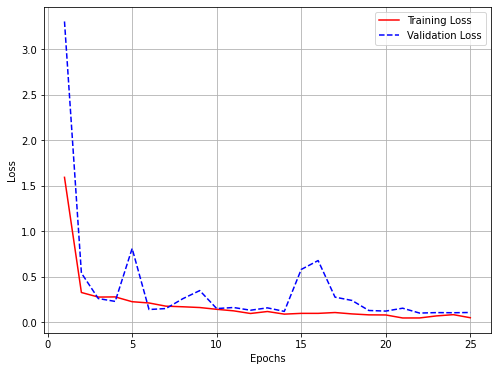

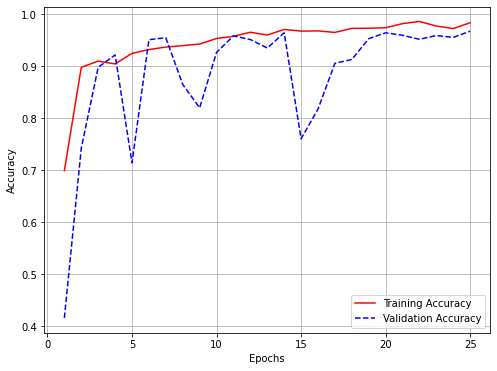

Garbage Collected : 5768

--------------------------------------------------



In [ ]:
torch.manual_seed(seed)
model = CNN_8BN(in_channels=cfg.in_channels, 
                filter_sizes=cfg.filter_sizes, 
                HL=cfg.HL, OL=cfg.OL, 
                AP_size=cfg.AP_size, DP=0.5)
optimizer = model.getOptimizer(A_S=True, lr=1e-3, wd=0)
scheduler = model.getPlateauLR(optimizer=optimizer, patience=5, eps=1e-8)

Losses, Accuracies, bestLossEpoch, bestAccsEpoch = fit_(model=model, optimizer=optimizer, scheduler=None, epochs=cfg.epochs,
                                                        trainloader=tr_data, validloader=va_data,
                                                        criterion=nn.NLLLoss(), device=cfg.device,
                                                        verbose=True)

LT = []
LV = []
AT = []
AV = []

for i in range(len(Losses)):
    LT.append(Losses[i]["train"])
    LV.append(Losses[i]["valid"])
    AT.append(Accuracies[i]["train"])
    AV.append(Accuracies[i]["valid"])

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LT))], LT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LV))], LV, "b--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(AT))], AT, "r", label="Training Accuracy")
plt.plot([i+1 for i in range(len(AV))], AV, "b--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

del model
torch.cuda.empty_cache()
breaker()
print("Garbage Collected : {}".format(gc.collect()))
breaker()

**Training CNN_11**


--------------------------------------------------

Training ...

--------------------------------------------------

Epoch: 1 | Train Loss: 1.48763 | Valid Loss: 3.20077 | Train Accuracy: 0.63365 | Valid Accuracy: 0.30793 | Time: 34.17 seconds
Epoch: 2 | Train Loss: 0.42896 | Valid Loss: 0.30552 | Train Accuracy: 0.84839 | Valid Accuracy: 0.88942 | Time: 34.23 seconds
Epoch: 3 | Train Loss: 0.31244 | Valid Loss: 0.57803 | Train Accuracy: 0.88783 | Valid Accuracy: 0.76298 | Time: 34.02 seconds
Epoch: 4 | Train Loss: 0.24705 | Valid Loss: 0.16361 | Train Accuracy: 0.91412 | Valid Accuracy: 0.93389 | Time: 34.06 seconds
Epoch: 5 | Train Loss: 0.22961 | Valid Loss: 0.15092 | Train Accuracy: 0.92074 | Valid Accuracy: 0.93822 | Time: 34.20 seconds
Epoch: 6 | Train Loss: 0.21055 | Valid Loss: 0.28281 | Train Accuracy: 0.92758 | Valid Accuracy: 0.87476 | Time: 34.16 seconds
Epoch: 7 | Train Loss: 0.20167 | Valid Loss: 0.44494 | Train Accuracy: 0.92584 | Valid Accuracy: 0.82548 | Time: 34.34 

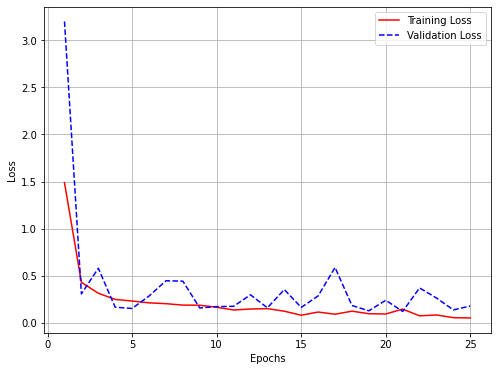

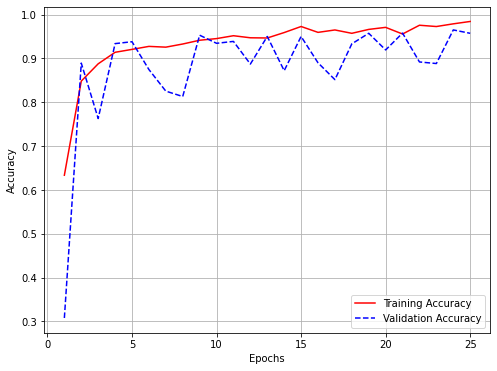

Garbage Collected : 5813

--------------------------------------------------



In [ ]:
torch.manual_seed(seed)
model = CNN_11BN(in_channels=cfg.in_channels, 
                filter_sizes=cfg.filter_sizes, 
                HL=cfg.HL, OL=cfg.OL, 
                AP_size=cfg.AP_size, DP=0.5)
optimizer = model.getOptimizer(A_S=True, lr=1e-3, wd=0)
scheduler = model.getPlateauLR(optimizer=optimizer, patience=5, eps=1e-8)

Losses, Accuracies, bestLossEpoch, bestAccsEpoch = fit_(model=model, optimizer=optimizer, scheduler=None, epochs=cfg.epochs,
                                                        trainloader=tr_data, validloader=va_data,
                                                        criterion=nn.NLLLoss(), device=cfg.device,
                                                        verbose=True)

LT = []
LV = []
AT = []
AV = []

for i in range(len(Losses)):
    LT.append(Losses[i]["train"])
    LV.append(Losses[i]["valid"])
    AT.append(Accuracies[i]["train"])
    AV.append(Accuracies[i]["valid"])

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LT))], LT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LV))], LV, "b--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(AT))], AT, "r", label="Training Accuracy")
plt.plot([i+1 for i in range(len(AV))], AV, "b--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

del model
torch.cuda.empty_cache()
breaker()
print("Garbage Collected : {}".format(gc.collect()))
breaker()

**Training CNN_13**


--------------------------------------------------

Training ...

--------------------------------------------------

Epoch: 1 | Train Loss: 1.26187 | Valid Loss: 3.07536 | Train Accuracy: 0.69352 | Valid Accuracy: 0.30793 | Time: 57.51 seconds
Epoch: 2 | Train Loss: 0.41109 | Valid Loss: 0.30770 | Train Accuracy: 0.85686 | Valid Accuracy: 0.90385 | Time: 57.25 seconds
Epoch: 3 | Train Loss: 0.28180 | Valid Loss: 0.31097 | Train Accuracy: 0.90575 | Valid Accuracy: 0.88221 | Time: 57.25 seconds
Epoch: 4 | Train Loss: 0.22257 | Valid Loss: 0.23266 | Train Accuracy: 0.92418 | Valid Accuracy: 0.93101 | Time: 57.60 seconds
Epoch: 5 | Train Loss: 0.24553 | Valid Loss: 0.21462 | Train Accuracy: 0.92025 | Valid Accuracy: 0.92260 | Time: 57.43 seconds
Epoch: 6 | Train Loss: 0.26446 | Valid Loss: 0.53331 | Train Accuracy: 0.91302 | Valid Accuracy: 0.78029 | Time: 57.49 seconds
Epoch: 7 | Train Loss: 0.17522 | Valid Loss: 0.20623 | Train Accuracy: 0.94816 | Valid Accuracy: 0.93510 | Time: 57.49 

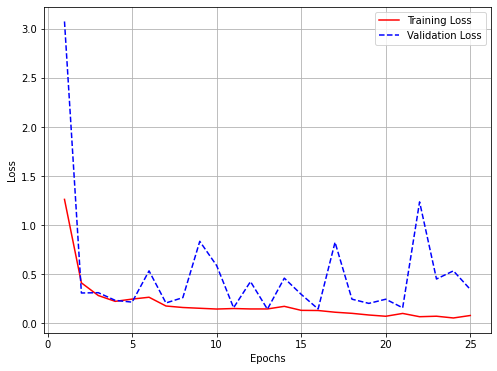

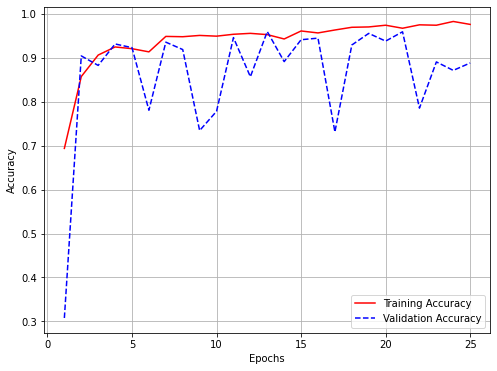

Garbage Collected : 5813

--------------------------------------------------



In [ ]:
torch.manual_seed(seed)
model = CNN_13BN(in_channels=cfg.in_channels, 
                filter_sizes=cfg.filter_sizes, 
                HL=cfg.HL, OL=cfg.OL, 
                AP_size=cfg.AP_size, DP=0.5)
optimizer = model.getOptimizer(A_S=True, lr=1e-3, wd=0)
scheduler = model.getPlateauLR(optimizer=optimizer, patience=5, eps=1e-8)

Losses, Accuracies, bestLossEpoch, bestAccsEpoch = fit_(model=model, optimizer=optimizer, scheduler=None, epochs=cfg.epochs,
                                                        trainloader=tr_data, validloader=va_data,
                                                        criterion=nn.NLLLoss(), device=cfg.device,
                                                        verbose=True)

LT = []
LV = []
AT = []
AV = []

for i in range(len(Losses)):
    LT.append(Losses[i]["train"])
    LV.append(Losses[i]["valid"])
    AT.append(Accuracies[i]["train"])
    AV.append(Accuracies[i]["valid"])

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(LT))], LT, "r", label="Training Loss")
plt.plot([i+1 for i in range(len(LV))], LV, "b--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot([i+1 for i in range(len(AT))], AT, "r", label="Training Accuracy")
plt.plot([i+1 for i in range(len(AV))], AV, "b--", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

del model
torch.cuda.empty_cache()
breaker()
print("Garbage Collected : {}".format(gc.collect()))
breaker()